In [33]:
import trimesh
import numpy as np

model = trimesh.load('./obj/model.stl')
samples, face_indexes = trimesh.sample.sample_surface_even(model, 300)

In [34]:
normals = []

for i in range(len(samples)):
    sample = samples[i]  # 표면 위의 샘플링된 점
    face_index = face_indexes[i]  # 해당 점이 속한 삼각형 면의 인덱스

    # 삼각형 면의 노말 벡터 가져오기
    normal = model.face_normals[face_index]

    # 샘플 점에서의 노말 벡터 추가
    normals.append(normal)

In [35]:
# samples

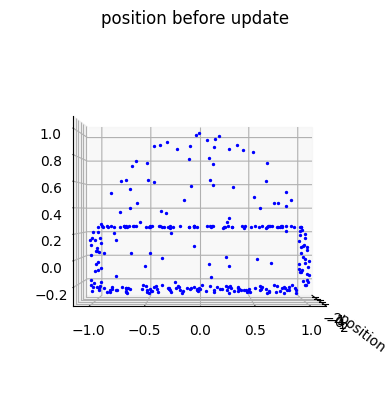

In [36]:
import matplotlib.pyplot as plt

# nums의 최소값과 최대값 구하기
min_num = np.min(samples)
max_num = np.max(samples)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(len(samples)):

    # 샘플링된 점 그리기
    ax.scatter(samples[i][0], samples[i][1], samples[i][2], marker= 'o', s=2, color='b')

ax.view_init(elev=0, azim=0)

plt.title('position before update')
plt.xlabel('position')
plt.show()

In [37]:
# from scipy.stats import norm
# 
# count = 0
# 
# while count < 100:
#     
#     # dens = []
#     vec = []
#     
#     for i in range(len(samples)):
#         # sum_pdf = 0
#         vec_total = 0
#         # 여기에 가우시안 넣어야 될듯
#         for num2 in samples:
#             if not np.array_equal(samples[i], num2):
#                 # gaussian 커널로 점들간 거리에 따라 확률추정
#                 # 이게 벡터의 크기
#                 distance = np.linalg.norm(samples[i] - num2)
#                 p = norm.pdf(distance, 0, 0.1)
#                 # 점 num에서 확률추정
#                 # sum_pdf += p
#                 vec_total += p * (samples[i]-num2) /distance
#                 
#                 vec_total += p * np.subtract(samples[i] - num2, np.dot(samples[i] - num2, normals[i]) * normals[i])
#                 # tangent = np.subtract(v1, np.dot(v1, normals[i]) * normals[i])
#                 
#         # dens.append(sum_pdf / (len(samples)-1))
#         vec.append(0.01 * vec_total)
#     
#     # dens /= np.sum(dens)
#     samples += vec
#     count += 1

In [38]:
from scipy.stats import norm
import numpy as np
from scipy.spatial.distance import cdist

# 가우시안 커널 함수
def gaussian_kernel(x, sigma=1):
    return np.exp(-0.5 * (x / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))

count = 0
enp = [float('inf')]

while True:
    diff_matrix = cdist(samples, samples)
    
    np.fill_diagonal(diff_matrix, np.inf)

    # 가우시안 커널 밀도 계산
    pdf_matrix = gaussian_kernel(diff_matrix)

    # 각 점에서의 밀도 및 벡터 업데이트 계산
    dens = np.sum(pdf_matrix, axis=1) / (len(samples) * (len(samples) - 1))
    vec = np.sum(pdf_matrix[:, :, np.newaxis] * (samples[:, np.newaxis, :] - samples[np.newaxis, :, :]) / diff_matrix[:, :, np.newaxis], axis=1)


    # 엔트로피 계산
    current_entropy = -np.sum(dens * np.log(dens + 1e-10))  # 확률분포로 정규화한 후 로그 엔트로피 계산

    enp.append(current_entropy)

    # 엔트로피 변화가 epsilon 이하일 때 중지
    if abs(enp[-2] - current_entropy) < 1e-10 and current_entropy == min(enp):
        break

    samples += 0.9 * vec  # vec의 크기 조절
    count += 1


273


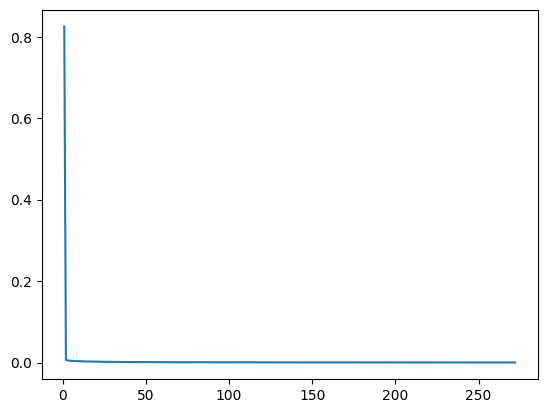

In [39]:
print(len(enp))
plt.plot(enp)

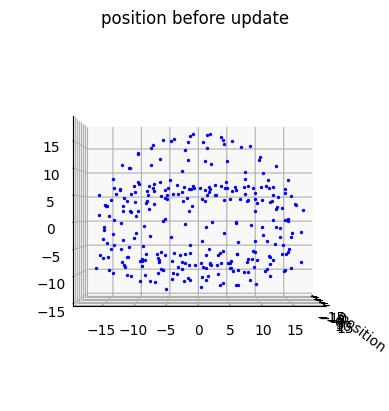

In [40]:
import matplotlib.pyplot as plt

# nums의 최소값과 최대값 구하기
min_num = np.min(samples)
max_num = np.max(samples)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(len(samples)):

    # 샘플링된 점 그리기
    ax.scatter(samples[i][0], samples[i][1], samples[i][2], marker= 'o', s=2, color='b')

ax.view_init(elev=0, azim= 0)

plt.title('position before update')
plt.xlabel('position')
plt.show()